<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-2">Importing libraries</a></span></li><li><span><a href="#Importing-data-(One-condition,-one-fault)" data-toc-modified-id="Importing-data-(One-condition,-one-fault)-3">Importing data (One condition, one fault)</a></span></li><li><span><a href="#Computing-remaining_useful_life(RUL),-target-variable" data-toc-modified-id="Computing-remaining_useful_life(RUL),-target-variable-4">Computing remaining_useful_life(RUL), target variable</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5">EDA</a></span></li><li><span><a href="#Linear-regression---base-model" data-toc-modified-id="Linear-regression---base-model-6">Linear regression - base model</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-7">Random Forest</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-Tuning-RF" data-toc-modified-id="Hyperparameter-Tuning-RF-7.1">Hyperparameter Tuning RF</a></span></li></ul></li><li><span><a href="#XGboost-regressor" data-toc-modified-id="XGboost-regressor-8">XGboost regressor</a></span><ul class="toc-item"><li><span><a href="#Hyperparameter-Tuning-XGboost" data-toc-modified-id="Hyperparameter-Tuning-XGboost-8.1">Hyperparameter Tuning XGboost</a></span></li></ul></li><li><span><a href="#Time-series" data-toc-modified-id="Time-series-9">Time series</a></span><ul class="toc-item"><li><span><a href="#Assumptions:-Stationarity" data-toc-modified-id="Assumptions:-Stationarity-9.1">Assumptions: Stationarity</a></span><ul class="toc-item"><li><span><a href="#Multicollinearity" data-toc-modified-id="Multicollinearity-9.1.1">Multicollinearity</a></span></li><li><span><a href="#Akaike-Information-Criterion(AIC):-finding-no.-of-lags" data-toc-modified-id="Akaike-Information-Criterion(AIC):-finding-no.-of-lags-9.1.2">Akaike Information Criterion(AIC): finding no. of lags</a></span></li></ul></li></ul></li><li><span><a href="#MLP" data-toc-modified-id="MLP-10">MLP</a></span><ul class="toc-item"><li><span><a href="#Scaling-is-important-for-Neural-network-models" data-toc-modified-id="Scaling-is-important-for-Neural-network-models-10.1">Scaling is important for Neural network models</a></span></li></ul></li><li><span><a href="#LSTM" data-toc-modified-id="LSTM-11">LSTM</a></span></li><li><span><a href="#Model-performance-on-test-dataset" data-toc-modified-id="Model-performance-on-test-dataset-12">Model performance on test dataset</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-13">SHAP</a></span></li><li><span><a href="#Conclusion-and-Future-Recommendation" data-toc-modified-id="Conclusion-and-Future-Recommendation-14">Conclusion and Future Recommendation</a></span></li><li><span><a href="#Resources-used" data-toc-modified-id="Resources-used-15">Resources used</a></span></li></ul></div>

# Objective
To predict the remaining usage life of turbofans using the sensor data. 

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from pylab import rcParams

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Time series
from statsmodels.tsa.stattools import adfuller 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

#mlp and lstm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking, LSTM

pd.set_option('display.max_columns', None)

# Importing data (One condition, one fault)

In [2]:
train = pd.read_csv('train_FD001.txt', sep='\s+', header = None)
fdtest = pd.read_csv('test_FD001.txt', sep ='\s+', header = None)
rul_test = pd.read_csv('RUL_FD001.txt', sep ='\s+', header = None)

In [3]:
train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
# Fixing column titles
index_names = ['ID', 'cycle']
setting_names = ['op_set1', 'op_set2', 'op_set3']
sensor_names = ['sensor{}'.format(i) for i in range(1,22)]
col_names = index_names + setting_names + sensor_names

In [5]:
train.columns = col_names
fdtest.columns = col_names
rul_test.columns = ['RUL']

In [6]:
train

,ID,cycle,op_set1,op_set2,op_set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [7]:
fdtest

,ID,cycle,op_set1,op_set2,op_set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,21.61,553.41,2388.02,9142.37,1.3,47.69,520.69,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,21.61,553.22,2388.05,9140.68,1.3,47.60,521.05,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,21.61,553.04,2388.11,9146.81,1.3,47.57,521.18,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,21.61,553.37,2388.07,9148.85,1.3,47.61,521.33,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699


In [8]:
rul_test

,RUL
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   op_set1   20631 non-null  float64
 3   op_set2   20631 non-null  float64
 4   op_set3   20631 non-null  float64
 5   sensor1   20631 non-null  float64
 6   sensor2   20631 non-null  float64
 7   sensor3   20631 non-null  float64
 8   sensor4   20631 non-null  float64
 9   sensor5   20631 non-null  float64
 10  sensor6   20631 non-null  float64
 11  sensor7   20631 non-null  float64
 12  sensor8   20631 non-null  float64
 13  sensor9   20631 non-null  float64
 14  sensor10  20631 non-null  float64
 15  sensor11  20631 non-null  float64
 16  sensor12  20631 non-null  float64
 17  sensor13  20631 non-null  float64
 18  sensor14  20631 non-null  float64
 19  sensor15  20631 non-null  float64
 20  sensor16  20631 non-null  fl

None of the column has null values. All columns look good.

In [10]:
train.describe()

,ID,cycle,op_set1,op_set2,op_set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,21.609803,553.367711,2388.096652,9065.242941,1.300000e+00,47.541168,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,0.001389,0.885092,0.070985,22.082880,4.660829e-13,0.267087,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,21.600000,549.850000,2387.900000,9021.730000,1.300000e+00,46.850000,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,21.610000,552.810000,2388.050000,9053.100000,1.300000e+00,47.350000,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,21.610000,553.440000,2388.090000,9060.660000,1.300000e+00,47.510000,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,21.610000,554.010000,2388.140000,9069.420000,1.300000e+00,47.700000,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,21.610000,556.060000,2388.560000,9244.590000,1.300000e+00,48.530000,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


Following sensor values do not change throughout operation: sensor1, sensor5, sensor6, sensor10, sensor16, sensor18, sensor19. We can remove them later. It's good idea to visualize all the sensors before removing them.

In [11]:
train[index_names].groupby('ID').max().describe()

,cycle
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


# Computing remaining_useful_life(RUL), target variable

In [12]:
def remaining_useful_life(df):
    # Get the total number of cycles for each unit
    max_cycle = df.groupby(by="ID")["cycle"].max()
    
    # Merge the max cycle back into the original frame
    result_df = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='ID', right_index=True)
    
    # Calculate remaining useful life for each row
    rul = result_df["max_cycle"] - result_df["cycle"]
    result_df["RUL"] = rul
    
    # drop max_cycle as it's no longer needed
    result_df = result_df.drop("max_cycle", axis=1)
    return result_df

In [13]:
train = remaining_useful_life(train)

In [14]:
train

,ID,cycle,op_set1,op_set2,op_set3,sensor1,sensor2,sensor3,sensor4,sensor5,sensor6,sensor7,sensor8,sensor9,sensor10,sensor11,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,21.61,551.43,2388.19,9065.52,1.3,48.07,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,21.61,550.86,2388.23,9065.11,1.3,48.04,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,21.61,550.94,2388.24,9065.90,1.3,48.09,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,21.61,550.68,2388.25,9073.72,1.3,48.39,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


RUL has been added to the train dataset. This will be our target variable and we will plot all the values against it.

# EDA

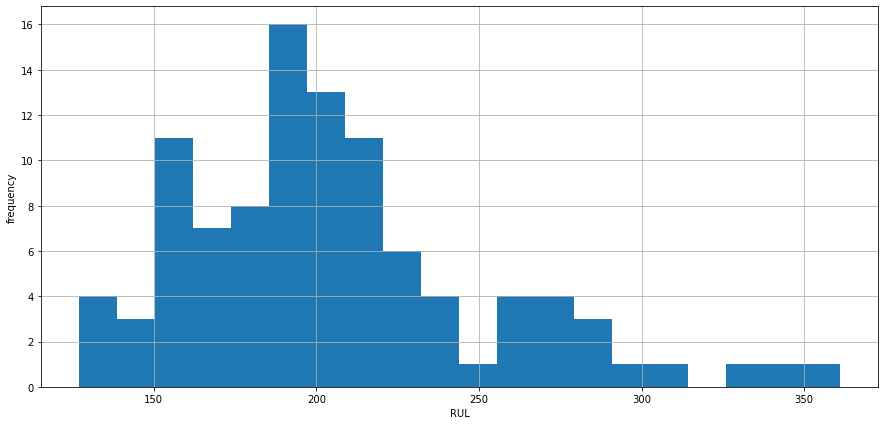

In [15]:
max_rul = train[['ID', 'RUL']].groupby('ID').max().reset_index()
max_rul['RUL'].hist(bins=20, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()

Remaining useful life of fans is right skewed with very few of them having cycle life over 300. Most of the turbofans break at about 200 cycles. The lowest cycle life is 128(from table). 

In [16]:
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['ID'].unique():
        plt.plot('RUL', sensor_name, data=train[train['ID']==i])
    plt.xlim(375, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 375, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

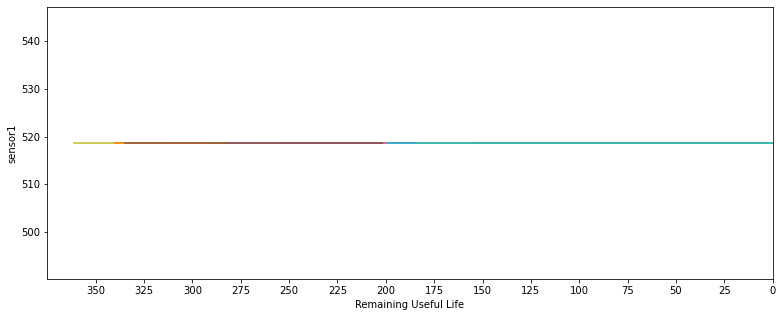

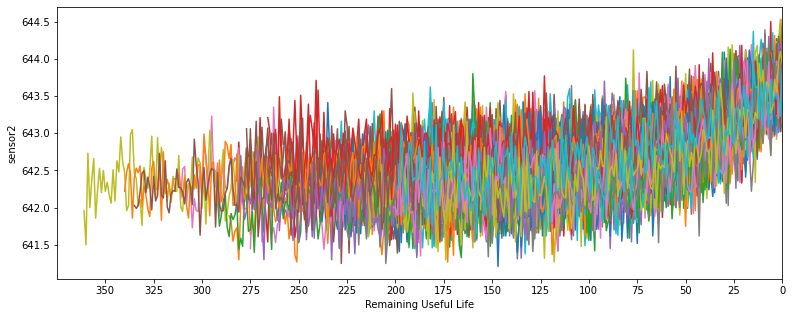

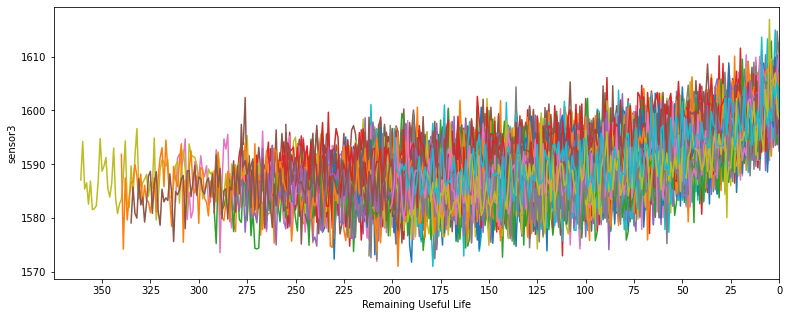

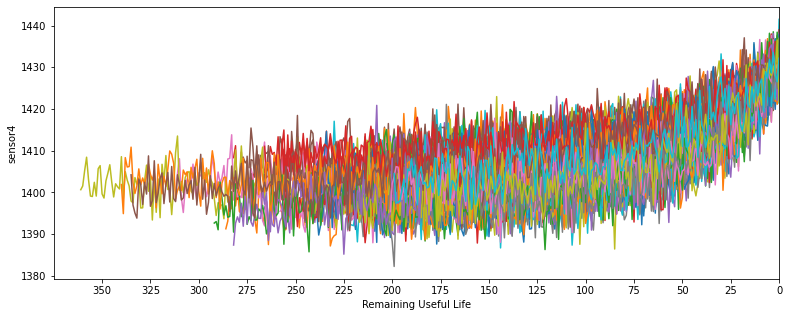

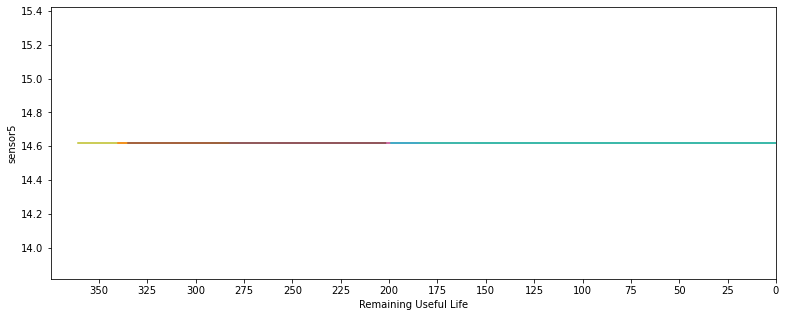

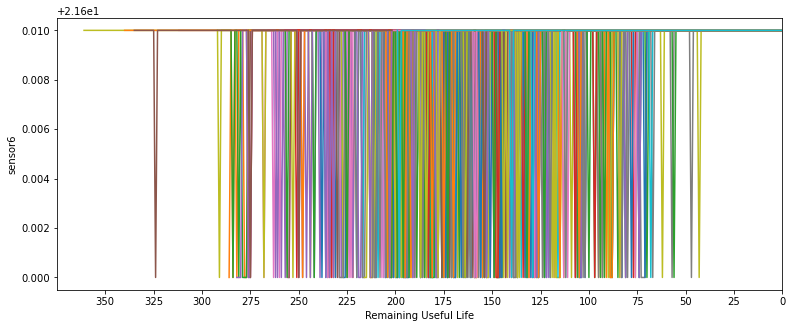

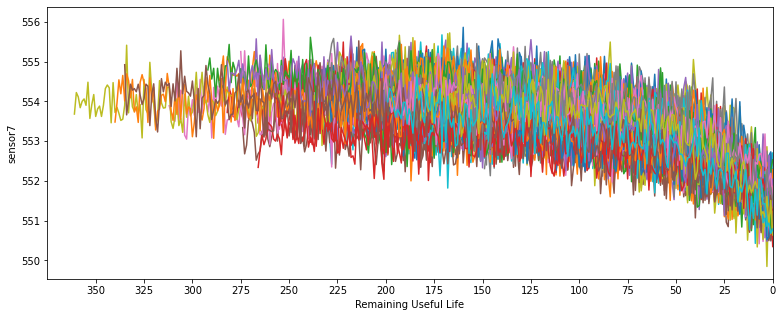

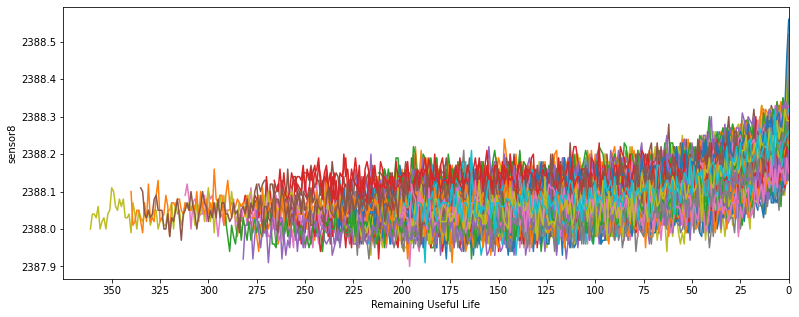

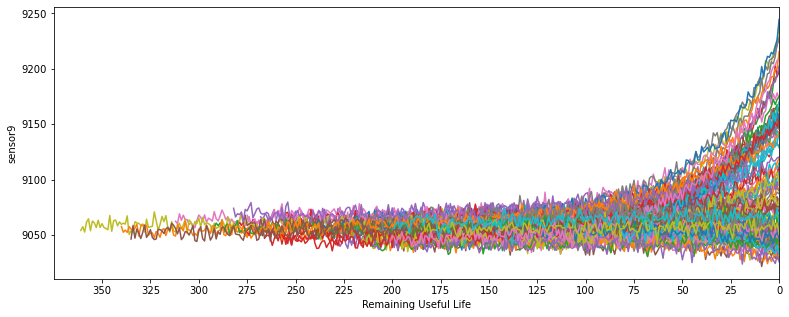

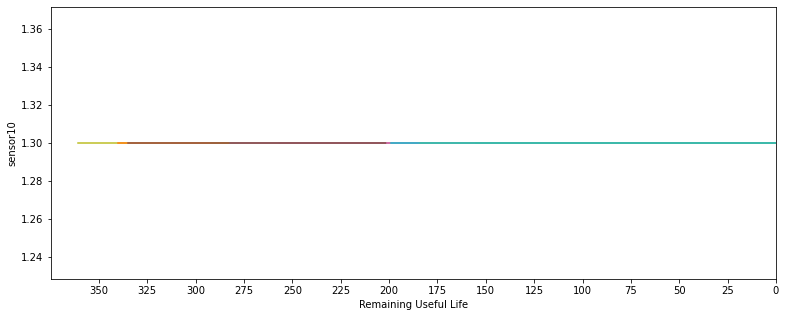

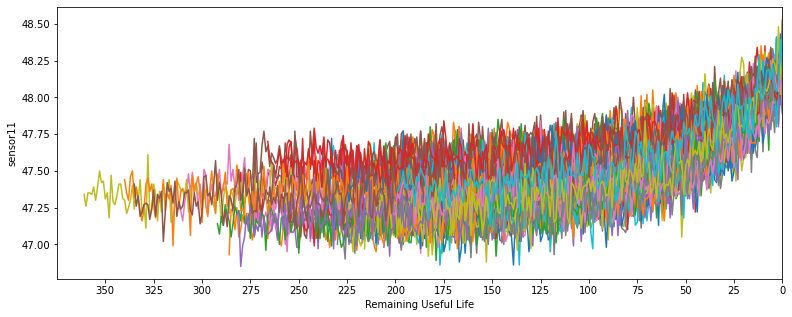

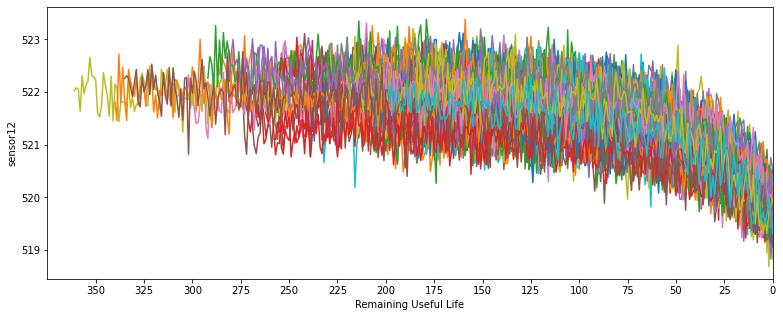

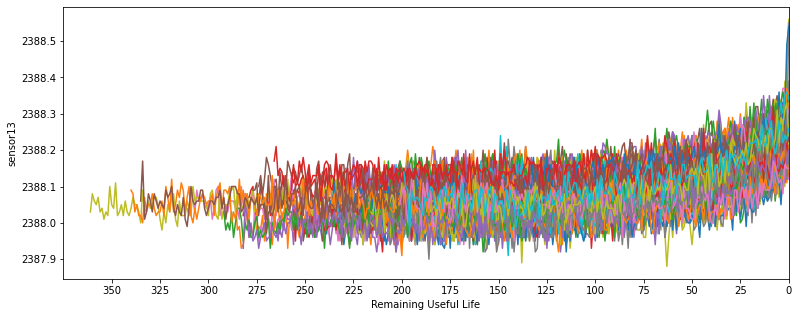

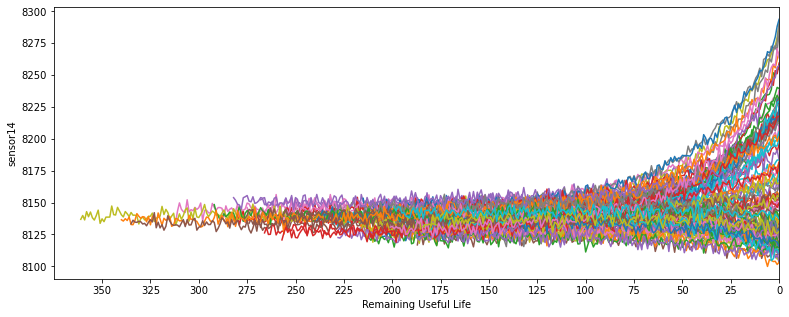

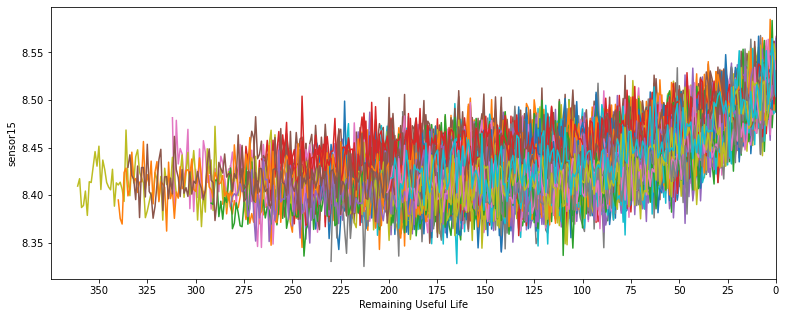

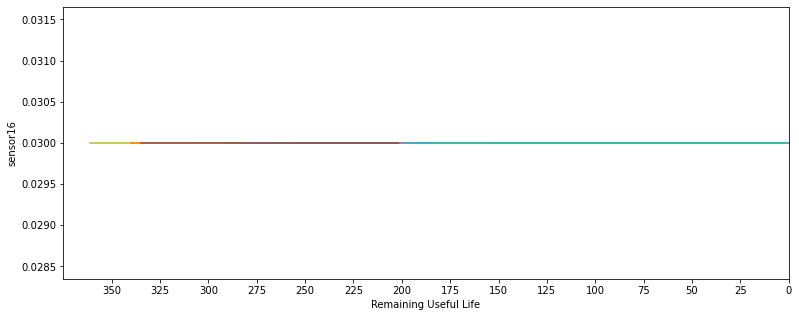

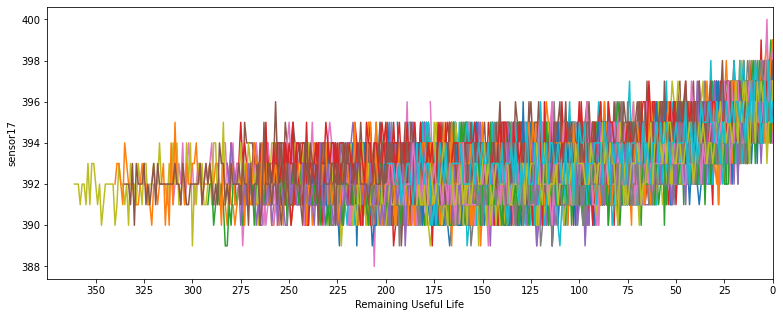

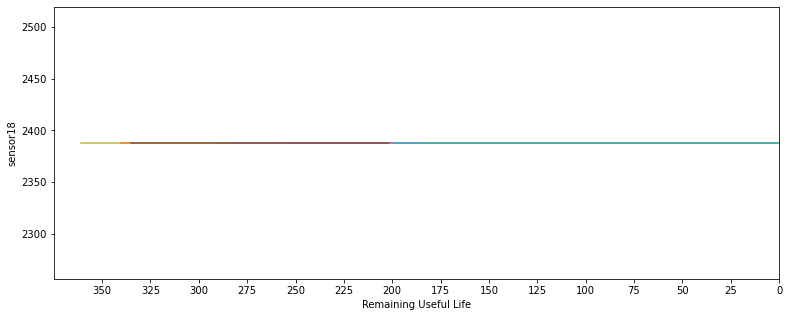

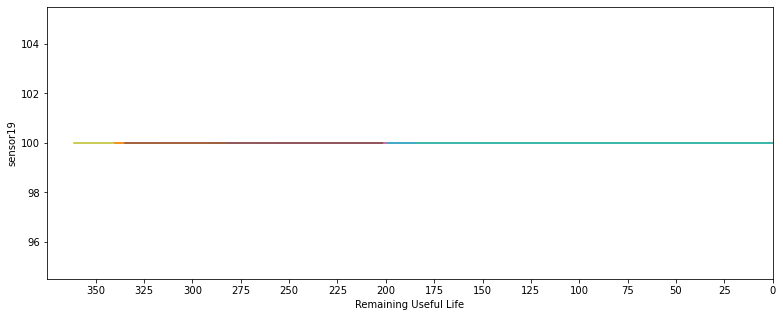

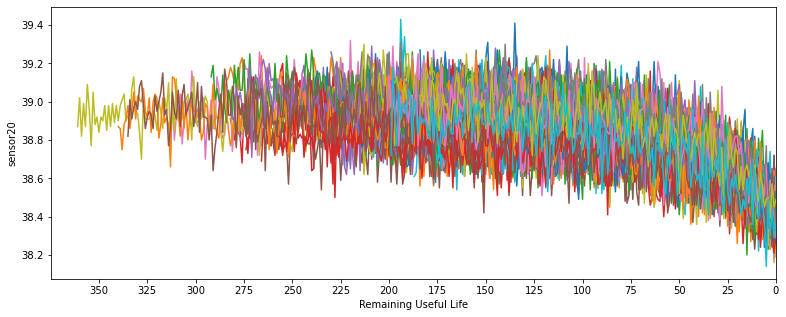

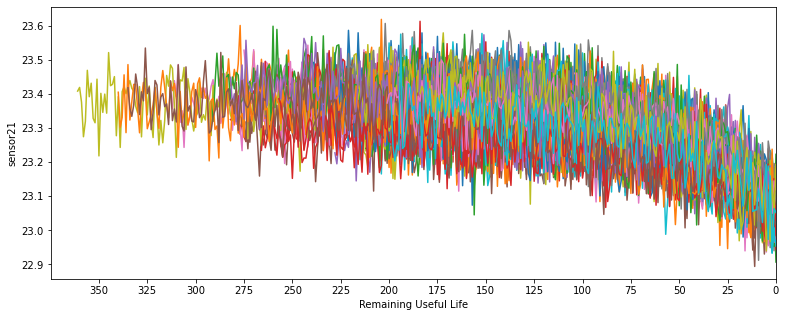

In [17]:
for sensor in sensor_names:
    plot_sensor(sensor)

sensor 1, 5, 6, 10, 16, 18 an 19 hold no information for remaining useful life. Dropping these columns before developing the model.

In [18]:
def evaluate(y_true, y_pred):
    lst = [round(mean_squared_error(y_true,y_pred),2)**0.5,
           round(r2_score(y_true,y_pred),2)]
    print('RMSE {:.2f}'.format(lst[0]))
    print('R2 {:.2f}'.format(lst[1]))
    return [round(lst[0],2), lst[1]*100]

In [19]:
# Dropping index names, settings and above mentioned sensors
drop_sensors = ['sensor1','sensor5','sensor6','sensor10','sensor16','sensor18','sensor19']
drop_labels = index_names+setting_names+drop_sensors

x = train.drop(drop_labels, axis=1)
y = x.pop('RUL')

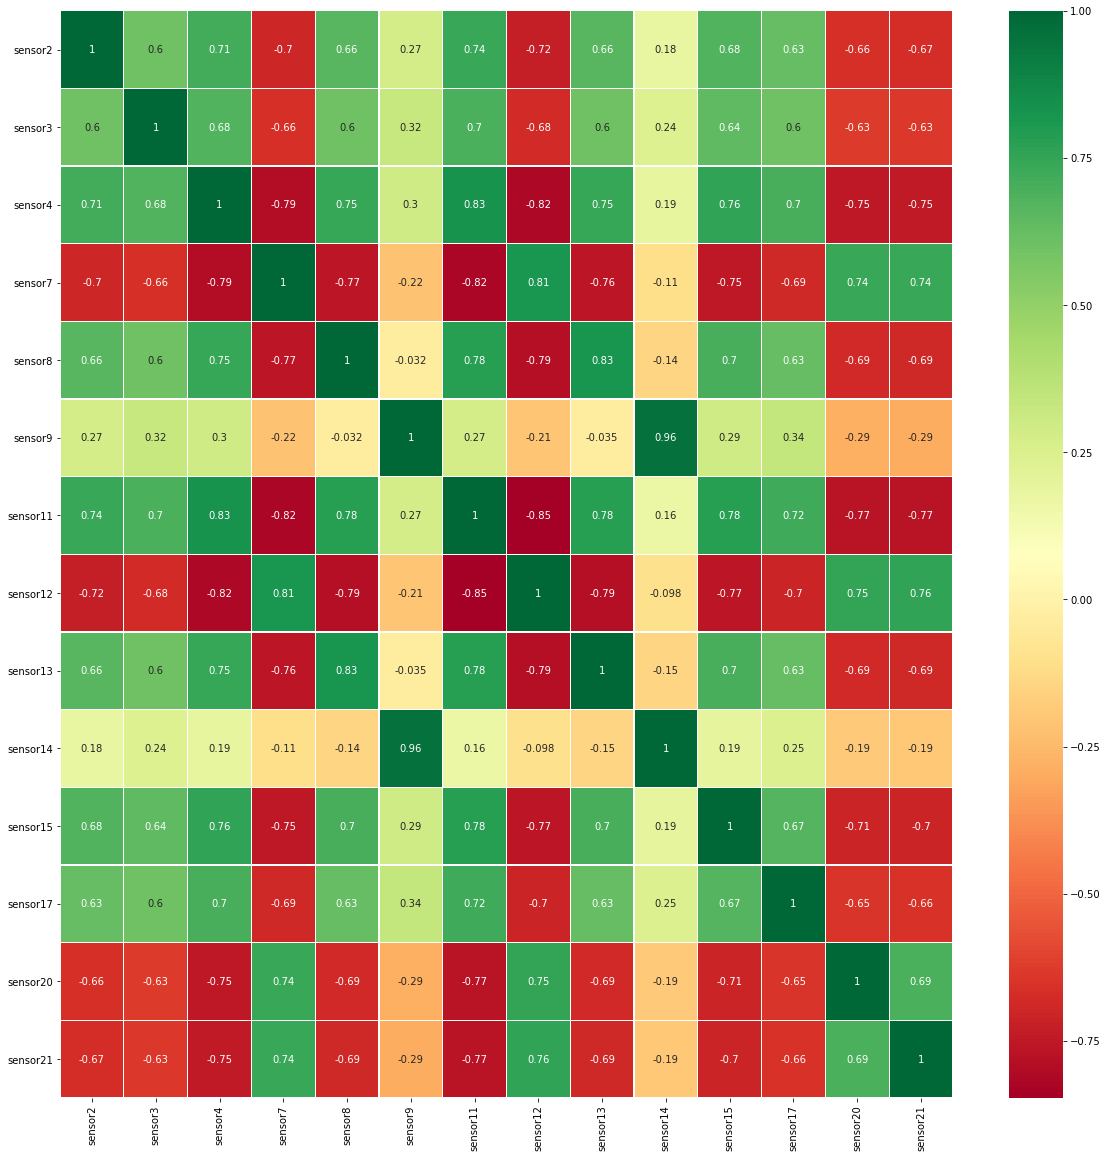

In [20]:
sns.heatmap(x.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

It's a good idea to check correlation between sensors. Here we can see that sensor 14 and sensor 9 are highly correlated(0.96). We can drop one of the sensor before model building.

In [21]:
x = x.drop('sensor9', axis=1)

# Linear regression - base model

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.70, random_state=42)  
# eventhough we set np and tf seeds, gss requires its own seed

def train_val_group_split(X, y, gss, df, col):
    
    for idx_train, idx_val in gss.split(X, y, groups=df[col]):
        
        X_train_split = X.iloc[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X.iloc[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
        print('train_split_engines', df.iloc[idx_train][col].unique(), '\n')
        print('validate_split_engines', df.iloc[idx_val][col].unique(), '\n')
    return X_train_split, y_train_split, X_val_split, y_val_split
split_result = train_val_group_split(x, y, gss, train, 'ID')
X_train, y_train, X_test, y_test = split_result

shuffle is set to false to split the dataset in such a way so that test contain data from same ID.

In [23]:
# create and fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# train predict and evaluate
y_pred_train = lr.predict(X_train)
print('Train')
evaluate(y_train, y_pred_train)

# test predict and evaluate
y_pred_test = lr.predict(X_test)
print('Test')
evaluate(y_test, y_pred_test)

Train
RMSE 46.41
R2 0.56
Test
RMSE 40.46
R2 0.61


[40.46, 61.0]

# Random Forest

In [24]:
# https://towardsdatascience.com/random-forest-for-predictive-maintenance-of-turbofan-engines-5260597e7e8f

rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)

# train predict and evaluate
y_pred_train = rf.predict(X_train)
print('Train')
evaluate(y_train, y_pred_train)

# test predict and evaluate
y_pred_test = rf.predict(X_test)
print('Test')
evaluate(y_test, y_pred_test)

Train
RMSE 16.23
R2 0.95
Test
RMSE 39.81
R2 0.63


[39.81, 63.0]

Overfitting on training sample. Hyperparameter tuning required.

## Hyperparameter Tuning RF

In [25]:
n_estimators = list(range(100, 500, 100))
max_depth = [None] + list(range(3, 30, 3))
min_samples_leaf = list(range(1, 100, 10))
max_features = ['auto', 'sqrt']

parameters = {
    'n_estimators' : n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'max_features' : max_features
}

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = parameters, 
                               n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 3, 6, 9, 12, 15, 18,
                                                      21, 24, 27],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 11, 21, 31, 41,
                                                             51, 61, 71, 81,
                                                             91],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, verbose=2)

In [26]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_leaf': 11,
 'max_features': 'sqrt',
 'max_depth': 12}

In [27]:
rf = rf_random.best_estimator_
rf.fit(X_train, y_train)

# train predict and evaluate
y_pred_train = rf.predict(X_train)
print('Train')
evaluate(y_train, y_pred_train)

# test predict and evaluate
y_pred_test = rf.predict(X_test)
print('Test')
evaluate(y_test, y_pred_test)

Train
RMSE 38.05
R2 0.71
Test
RMSE 39.11
R2 0.64


[39.11, 64.0]

I can use GridsearchCV for further tuning. At the moment I will try xgboost and check performance.

# XGboost regressor

In [28]:
xg_reg = xgb.XGBRegressor(random_state = 42)
xg_reg.fit(X_train, y_train)

# train predict and evaluate
y_pred_train = xg_reg.predict(X_train)
print('Train')
evaluate(y_train, y_pred_train)

# test predict and evaluate
y_pred_test = xg_reg.predict(X_test)
print('Test')
evaluate(y_test, y_pred_test)

Train
RMSE 26.82
R2 0.85
Test
RMSE 41.79
R2 0.59


[41.79, 59.0]

Overfitting on training sample. Hyperparameter tuning required.

## Hyperparameter Tuning XGboost

In [29]:
params = {'max_depth': list(range(3, 30, 3)),
          'learning_rate': [0.01, 0.1, 0.2, 0.3],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.4, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
          'n_estimators': list(range(100, 500, 100))}

xgbr = xgb.XGBRegressor()

xgbr_random = RandomizedSearchCV(estimator=xgbr,
                                 param_distributions=params,
                                 scoring='neg_mean_squared_error', random_state=42,
                                 n_jobs =-1, n_iter=100,verbose=2)

xgbr_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bylevel': array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'colsample_bytree': array([0

In [30]:
xgbr_random.best_params_

{'subsample': 0.7999999999999999,
 'n_estimators': 100,
 'max_depth': 3,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7999999999999999,
 'colsample_bylevel': 0.7}

In [31]:
xg_reg= xgbr_random.best_estimator_
xg_reg.fit(X_train, y_train)

# train predict and evaluate
y_pred_train = xg_reg.predict(X_train)
print('Train')
evaluate(y_train, y_pred_train)

# test predict and evaluate
y_pred_test = xg_reg.predict(X_test)
print('Test')
evaluate(y_test, y_pred_test)

Train
RMSE 41.64
R2 0.65
Test
RMSE 39.36
R2 0.64


[39.36, 64.0]

RF performs better.

# Time series
Since the sensor data is noted down after each cycle, they are related to time series and hence I wanted to use it to check the performance on predictions using time series.
## Assumptions: Stationarity

In [32]:
# https://towardsdatascience.com/time-series-analysis-for-predictive-maintenance-of-turbofan-engines-1b3864991da4

## function to convert sensors into stationarity using Augmented Dickey-Fuller test. The more negative the test statistic, 
## the more stationary the signal. When the p-value is below 0.05, it can be assumed the time-series is stationary.
def find_max_diff(series):
    maxdiff = 0
    do = True
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series, maxlag=1)
    if pvalue < 0.05:
        do = False
    
    while do:
        maxdiff += 1
        adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(series.diff(maxdiff).dropna(), maxlag=1)
        if pvalue < 0.05:  # if significant, stop differencing and testing for stationarity
            do = False
    return maxdiff


def make_stationary(df_input, columns):
    df = df_input.copy()
    for unit_nr in range(1, df['ID'].max()+1):
        for col in columns:
            maxdiff = find_max_diff(df.loc[df['ID']==unit_nr, col])
            if maxdiff > 0:
                df.loc[df['ID']==unit_nr, col] = df.loc[df['ID']==unit_nr, col].diff(maxdiff)
    df.dropna(inplace=True)
    return df

In [33]:
remaining_sensors = X_train.columns.difference(index_names+['RUL'])
drop = setting_names+drop_sensors+['sensor9']

# make all remaining sensors stationary per unit_nr
stat_df = train.drop(drop, axis=1)

### Multicollinearity
Multicollinearity influences the models’ coefficients and stability, increasing the chance of incorrect results on new data. Multicollinearity may be heavily influenced by scaling. We are going to scale all the sensors.

In [34]:
scaler = StandardScaler()
scaler.fit(stat_df[remaining_sensors])
stat_df[remaining_sensors] = scaler.transform(stat_df[remaining_sensors])

stat_df = make_stationary(stat_df, remaining_sensors)

### Akaike Information Criterion(AIC): finding no. of lags

In [35]:
## Function for adding lags
def add_lagged_variables(df_input, nr_of_lags, columns):
    df = df_input.copy()
    for i in range(nr_of_lags):
        lagged_columns = [col + '_lag_{}'.format(i+1) for col in columns]
        df[lagged_columns] = df.groupby('ID')[columns].shift(i+1)
    df.dropna(inplace=True)
    return df

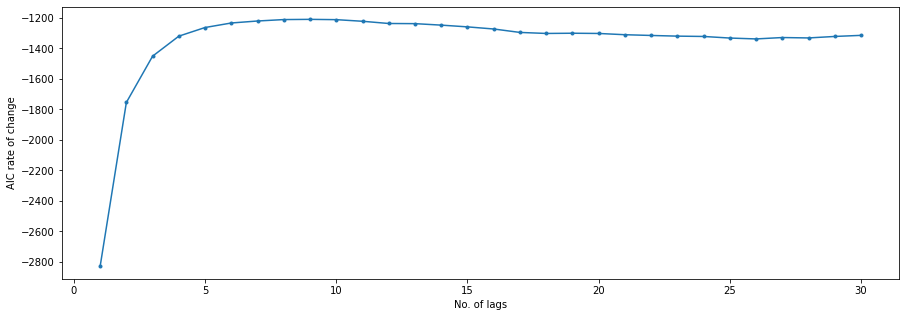

In [36]:
# add lags and evaluate models to find optimal lag length

metrics = pd.DataFrame(columns=['rmse', 'AIC', 'BIC'])
nr_of_lags = 30
for i in range(0, nr_of_lags+1):
    X_train = add_lagged_variables(stat_df, i, remaining_sensors)
    X_train = X_train.drop(index_names, axis=1)
    y_train = X_train.pop('RUL')
    
    model = sm.OLS(y_train, sm.add_constant(X_train.values))
    result = model.fit()

    metrics = metrics.append(pd.DataFrame(data=[[np.sqrt(result.mse_resid), round(result.aic,2), round(result.bic,2)]],
                               columns=['rmse', 'AIC', 'BIC']),
                               ignore_index = True)
    
## Plot 
plt.figure(figsize=(15,5))
plt.plot(metrics['AIC'].diff(), marker='.')  # plot the difference to see where it flattens out
plt.xlabel("No. of lags")
plt.ylabel("AIC rate of change")
plt.show()

After 8 number of lags AIC seems to flatten out. Adding more lags (complexity) no longer substantially improves model quality.

Checking multicollinearity by calculating Variance Inflation Factor(VIF), s a rule of thumb vif-values below 5 are considered safe.

In [37]:
X_train = add_lagged_variables(stat_df, 8, remaining_sensors)
X_train = X_train.drop(index_names, axis=1)

vifs = {X_train.columns[i]:round(vif(X_train.values, i), 2) for i in range(len(X_train.columns))}
display(vifs)

{'sensor2': 2.53,
 'sensor3': 2.28,
 'sensor4': 1.98,
 'sensor7': 2.1,
 'sensor8': 2.27,
 'sensor11': 1.74,
 'sensor12': 1.85,
 'sensor13': 2.27,
 'sensor14': 4.41,
 'sensor15': 2.45,
 'sensor17': 2.42,
 'sensor20': 2.57,
 'sensor21': 2.64,
 'RUL': 1.76,
 'sensor11_lag_1': 2.0,
 'sensor12_lag_1': 2.0,
 'sensor13_lag_1': 2.32,
 'sensor14_lag_1': 4.63,
 'sensor15_lag_1': 2.39,
 'sensor17_lag_1': 2.38,
 'sensor2_lag_1': 2.49,
 'sensor20_lag_1': 2.51,
 'sensor21_lag_1': 2.59,
 'sensor3_lag_1': 2.24,
 'sensor4_lag_1': 2.11,
 'sensor7_lag_1': 2.17,
 'sensor8_lag_1': 2.32,
 'sensor11_lag_2': 1.88,
 'sensor12_lag_2': 1.92,
 'sensor13_lag_2': 2.26,
 'sensor14_lag_2': 4.42,
 'sensor15_lag_2': 2.34,
 'sensor17_lag_2': 2.35,
 'sensor2_lag_2': 2.45,
 'sensor20_lag_2': 2.48,
 'sensor21_lag_2': 2.54,
 'sensor3_lag_2': 2.21,
 'sensor4_lag_2': 2.01,
 'sensor7_lag_2': 2.08,
 'sensor8_lag_2': 2.27,
 'sensor11_lag_3': 1.76,
 'sensor12_lag_3': 1.84,
 'sensor13_lag_3': 2.22,
 'sensor14_lag_3': 4.27,
 'senso

All looks good as vif is less than 5 for all of them.

In [38]:
# train and evaluate model with 0 to n lags
lags = 8

# prep data
X_train_interim = train.drop(drop, axis=1)
X_train_interim[remaining_sensors] = scaler.transform(X_train_interim[remaining_sensors])
X_train_interim = make_stationary(X_train_interim, remaining_sensors)
X_train_interim = add_lagged_variables(X_train_interim, lags, remaining_sensors)
X_train_interim = sm.add_constant(X_train_interim)
XT = X_train_interim.drop(index_names, axis=1)
yT = XT.pop("RUL")

In [39]:
split_result_T = train_val_group_split(XT, yT, gss, X_train_interim, 'ID')
XT_train, yT_train, XT_test, yT_test = split_result_T

train_split_engines [  2   3   4   6   7   8   9  12  14  15  17  18  20  21  22  24  25  26
  28  29  30  33  35  36  37  38  39  42  44  47  48  49  50  51  52  53
  55  57  58  59  60  61  62  63  64  65  66  67  68  69  72  75  76  79
  80  82  83  85  86  87  88  90  92  93  94  95  96  98  99 100] 

validate_split_engines [ 1  5 10 11 13 16 19 23 27 31 32 34 40 41 43 45 46 54 56 70 71 73 74 77
 78 81 84 89 91 97] 



In [40]:
# fit model
TSmodel = sm.OLS(yT_train, XT_train)
modelTS = TSmodel.fit()

# train predict and evaluate
yT_pred_train = modelTS.predict(XT_train)
print('Train')
evaluate(yT_train, yT_pred_train)

# test predict and evaluate
yT_pred_test = modelTS.predict(XT_test)
print('Test')
evaluate(yT_test, yT_pred_test)

Train
RMSE 41.91
R2 0.62
Test
RMSE 39.25
R2 0.61


[39.25, 61.0]

Adding time series to the model improved the RMSE as compared to base model.

# MLP

## Scaling is important for Neural network models

In [41]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(x[remaining_sensors])
x_scaled = x.copy()
x_scaled[remaining_sensors] = pd.DataFrame(min_max_scaler.transform(x[remaining_sensors]), columns=remaining_sensors)

split_result_scaled = train_val_group_split(x_scaled, y, gss, train, 'ID')
X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled = split_result_scaled

train_split_engines [  2   3   4   6   7   8   9  12  14  15  17  18  20  21  22  24  25  26
  28  29  30  33  35  36  37  38  39  42  44  47  48  49  50  51  52  53
  55  57  58  59  60  61  62  63  64  65  66  67  68  69  72  75  76  79
  80  82  83  85  86  87  88  90  92  93  94  95  96  98  99 100] 

validate_split_engines [ 1  5 10 11 13 16 19 23 27 31 32 34 40 41 43 45 46 54 56 70 71 73 74 77
 78 81 84 89 91 97] 



In [42]:
input_dim = len(remaining_sensors)

model = Sequential()
model.add(Dense(16, input_dim=input_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

epochs = 15

mlp = model.fit(X_train_scaled[remaining_sensors], y_train_scaled, 
                validation_data=(X_test_scaled[remaining_sensors], y_test_scaled),epochs=epochs)

Epoch 1/15
454/454 [==============================] - 1s 1ms/step - loss: 6420.2334 - val_loss: 1798.3190
Epoch 2/15
454/454 [==============================] - 0s 728us/step - loss: 2222.4180 - val_loss: 1723.1099
Epoch 3/15
454/454 [==============================] - 0s 701us/step - loss: 2124.2632 - val_loss: 1663.6722
Epoch 4/15
454/454 [==============================] - 0s 734us/step - loss: 2067.4314 - val_loss: 1620.9652
Epoch 5/15
454/454 [==============================] - 0s 735us/step - loss: 2033.2571 - val_loss: 1590.2249
Epoch 6/15
454/454 [==============================] - 0s 735us/step - loss: 2010.7620 - val_loss: 1581.8451
Epoch 7/15
454/454 [==============================] - 0s 770us/step - loss: 1988.7275 - val_loss: 1601.8088
Epoch 8/15
454/454 [==============================] - 0s 845us/step - loss: 1992.6010 - val_loss: 1536.3707
Epoch 9/15
454/454 [==============================] - 0s 915us/step - loss: 1968.5446 - val_loss: 1551.5299
Epoch 10/15
454/454 [=========

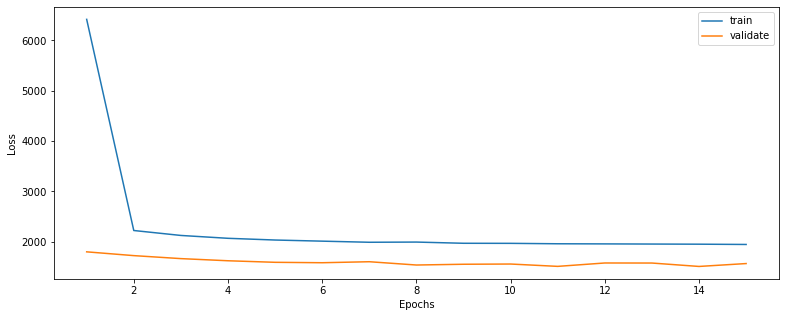

In [43]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(mlp)

In [44]:
yN_pred_train = model.predict(X_train_scaled)
print('Train')
evaluate(y_train_scaled, yN_pred_train)

yN_pred_test = model.predict(X_test_scaled)
print('Test')
evaluate(y_test_scaled, yN_pred_test)

Train
RMSE 120.88
R2 -1.95
Test
RMSE 114.96
R2 -2.11


[114.96, -211.0]

Results are bad with mlp model. Lets check the model with added lag model previously done in time serires.

In [45]:
input_dim1 = len(XT_train.columns)
dropout =0.2

model1 = Sequential()
model1.add(Dense(16, input_dim=input_dim1, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(dropout))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

epochs1 = 12

mlpT = model1.fit(XT_train, yT_train, validation_data=(XT_test, yT_test), epochs=epochs1)

Epoch 1/12
434/434 [==============================] - 1s 1ms/step - loss: 4479.4341 - val_loss: 1745.1182
Epoch 2/12
434/434 [==============================] - 0s 983us/step - loss: 1617.0605 - val_loss: 1569.2249
Epoch 3/12
434/434 [==============================] - 0s 1ms/step - loss: 1456.5117 - val_loss: 1524.8523
Epoch 4/12
434/434 [==============================] - 0s 1ms/step - loss: 1385.8547 - val_loss: 1486.7128
Epoch 5/12
434/434 [==============================] - 0s 1ms/step - loss: 1341.5270 - val_loss: 1370.2847
Epoch 6/12
434/434 [==============================] - 0s 1ms/step - loss: 1320.1997 - val_loss: 1408.3010
Epoch 7/12
434/434 [==============================] - 0s 1ms/step - loss: 1315.4672 - val_loss: 1391.1371
Epoch 8/12
434/434 [==============================] - 0s 1ms/step - loss: 1286.2871 - val_loss: 1302.7095
Epoch 9/12
434/434 [==============================] - 0s 1ms/step - loss: 1270.9905 - val_loss: 1272.4900
Epoch 10/12
434/434 [=======================

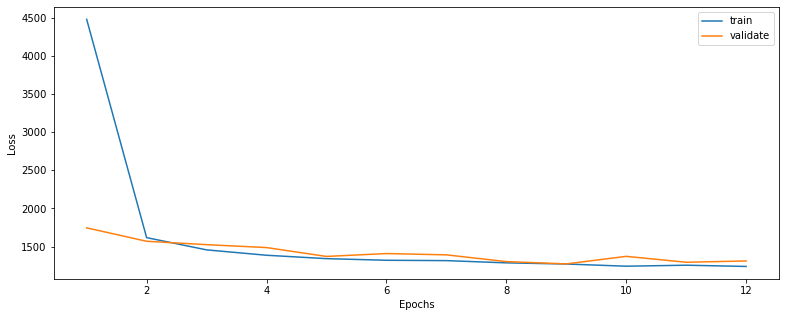

In [46]:
plot_loss(mlpT)

In [47]:
yN_pred_train = model1.predict(XT_train)
print('Train')
evaluate(yT_train, yN_pred_train)

yN_pred_test = model1.predict(XT_test)
print('Test')
evaluate(yT_test, yN_pred_test)

Train
RMSE 32.77
R2 0.77
Test
RMSE 36.21
R2 0.67


[36.21, 67.0]

This results looks much better than base model. Hyperparameter tuning can be done further.

# LSTM

In [48]:
# data preprocessing for lstm model
def gen_train_data(df, sequence_length, columns):
    data = df[columns].values
    num_elements = data.shape[0]

    # -1 and +1 because of Python indexing
    for start, stop in zip(range(0, num_elements-(sequence_length-1)), range(sequence_length, num_elements+1)):
        yield data[start:stop, :]
        
        
def gen_data_wrapper(df, sequence_length, columns, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['ID'].unique()
        
    data_gen = (list(gen_train_data(df[df['ID']==unit_nr], sequence_length, columns))
               for unit_nr in unit_nrs)
    data_array = np.concatenate(list(data_gen)).astype(np.float32)
    return data_array

In [49]:
def gen_labels(df, sequence_length, label):
    data_matrix = df[label].values
    num_elements = data_matrix.shape[0]

    # -1 because I want to predict the rul of that last row in the sequence, not the next row
    return data_matrix[sequence_length-1:num_elements, :]  

def gen_label_wrapper(df, sequence_length, label, unit_nrs=np.array([])):
    if unit_nrs.size <= 0:
        unit_nrs = df['ID'].unique()
        
    label_gen = [gen_labels(df[df['ID']==unit_nr], sequence_length, label) 
                for unit_nr in unit_nrs]
    label_array = np.concatenate(label_gen).astype(np.float32)
    return label_array

In [50]:
## test padding
def gen_test_data(df, sequence_length, columns, mask_value):
    if df.shape[0] < sequence_length:
        data_matrix = np.full(shape=(sequence_length, len(columns)), fill_value=mask_value) # pad
        idx = data_matrix.shape[0] - df.shape[0]
        data_matrix[idx:,:] = df[columns].values  # fill with available data
    else:
        data_matrix = df[columns].values
        
    # specifically yield the last possible sequence
    stop = num_elements = data_matrix.shape[0]
    start = stop - sequence_length
    for i in list(range(1)):
        yield data_matrix[start:stop, :]

In [51]:
sequence_length = 30

X_train_interim = train.drop(drop, axis=1)
X_train_interim[remaining_sensors] = min_max_scaler.transform(X_train_interim[remaining_sensors])


# train-val split
gss = GroupShuffleSplit(n_splits=1, train_size=0.70, random_state=42)
for train_unit, val_unit in gss.split(X_train_interim['ID'].unique(), groups=X_train_interim['ID'].unique()):
    train_unit = X_train_interim['ID'].unique()[train_unit]  # gss returns indexes and index starts at 1
    val_unit = X_train_interim['ID'].unique()[val_unit]

    train_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, train_unit)
    train_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], train_unit)
    
    val_split_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors, val_unit)
    val_split_label = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'], val_unit)

# create sequences train, test 
train_array = gen_data_wrapper(X_train_interim, sequence_length, remaining_sensors)
label_array = gen_label_wrapper(X_train_interim, sequence_length, ['RUL'])


In [52]:
model2 = Sequential()
model2.add(Masking(mask_value=-99., input_shape=(sequence_length, train_array.shape[2])))
model2.add(LSTM(32, activation='tanh'))
model2.add(Dropout(0.2))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='adam')
history = model2.fit(train_split_array, train_split_label,
                    validation_data=(val_split_array, val_split_label),
                    epochs=30,
                   batch_size=32)

Epoch 1/30
390/390 [==============================] - 8s 15ms/step - loss: 10980.3945 - val_loss: 8504.8750
Epoch 2/30
390/390 [==============================] - 5s 13ms/step - loss: 8905.4531 - val_loss: 6936.8877
Epoch 3/30
390/390 [==============================] - 6s 14ms/step - loss: 7470.8057 - val_loss: 5766.6274
Epoch 4/30
390/390 [==============================] - 6s 15ms/step - loss: 6388.8892 - val_loss: 4904.5088
Epoch 5/30
390/390 [==============================] - 6s 14ms/step - loss: 5602.5908 - val_loss: 4287.3931
Epoch 6/30
390/390 [==============================] - 6s 14ms/step - loss: 5030.2271 - val_loss: 3866.9707
Epoch 7/30
390/390 [==============================] - 5s 14ms/step - loss: 4638.5435 - val_loss: 3600.5281
Epoch 8/30
390/390 [==============================] - 5s 14ms/step - loss: 4408.7905 - val_loss: 3446.1218
Epoch 9/30
390/390 [==============================] - 5s 14ms/step - loss: 4250.5430 - val_loss: 3366.2976
Epoch 10/30
390/390 [===============

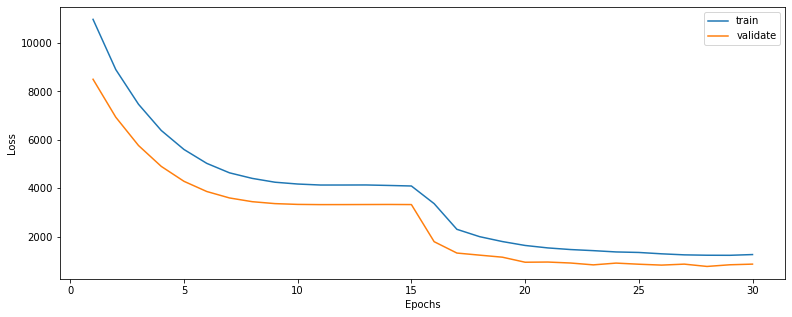

In [53]:
def plot_loss(fit_history):
    plt.figure(figsize=(13,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

In [54]:
y_hat_train = model2.predict(train_split_array)
print('Train')
evaluate(train_split_label, y_hat_train)

y_hat_val = model2.predict(val_split_array)
print('Val_test')
evaluate(val_split_label, y_hat_val) 

Train
RMSE 32.47
R2 0.74
Val_test
RMSE 29.43
R2 0.74


[29.43, 74.0]

LSTM seems to perform the best among all the models implemented.

# Model performance on test dataset

In [55]:
# models: Lr, rf, xg, timeseries, mlp(timeseries), lstm
# test data, only last value reqd for lr, rf, xg
X_test_final= fdtest.groupby('ID').last().reset_index().drop(drop_labels+['sensor9'], axis=1)

# test data preprocess reqd for time series and lstm
## TimeSeries
X_test_interim = fdtest.drop(drop, axis=1)
X_test_interim[remaining_sensors] = scaler.transform(X_test_interim[remaining_sensors])
X_test_interim = make_stationary(X_test_interim, remaining_sensors)
X_test_interim = add_lagged_variables(X_test_interim, lags, remaining_sensors)
X_test_interim = X_test_interim.groupby('ID').last().reset_index()
X_test_interim = sm.add_constant(X_test_interim)
X_test_ts = X_test_interim.drop(index_names, axis=1)

## LSTM
X_test_interim_lstm = fdtest.drop(drop, axis=1)
X_test_interim_lstm[remaining_sensors] = min_max_scaler.transform(X_test_interim_lstm[remaining_sensors])
test_gen = (list(gen_test_data(X_test_interim_lstm[X_test_interim_lstm['ID']==unit_nr], sequence_length, remaining_sensors, -99.))
           for unit_nr in X_test_interim_lstm['ID'].unique())
test_array = np.concatenate(list(test_gen)).astype(np.float32)

In [56]:
y_lr = lr.predict(X_test_final)
print('LinearRegression')
LR_score_lst = evaluate(rul_test, y_lr)

y_rf = rf.predict(X_test_final)
print('RFRegression')
RF_score_lst = evaluate(rul_test, y_rf)

y_xg = xg_reg.predict(X_test_final)
print('XGRegression')
XGB_score_lst = evaluate(rul_test, y_xg)

y_ts = modelTS.predict(X_test_ts)
print('TSRegression')
evaluate(rul_test, y_ts)

y_tsmlp = model1.predict(X_test_ts)
print('mlp')
evaluate(rul_test, y_tsmlp)

y_lstm = model2.predict(test_array)
print('lstm')
LSTM_score_lst = evaluate(rul_test, y_lstm)

LinearRegression
RMSE 32.03
R2 0.41
RFRegression
RMSE 31.42
R2 0.43
XGRegression
RMSE 32.48
R2 0.39
TSRegression
RMSE 42.53
R2 -0.05
mlp
RMSE 91.83
R2 -3.88
lstm
RMSE 29.52
R2 0.50


LSTM model performs the best for the unseen test data. It can predict the remaining usage life within 30 cycles and can give us the warning more accurately than the others. We can also see that time series and mlp(timeseries) have negative r2 score value, meaning they don't follow the trend of data. We will discard these two models.

In [57]:
def Bar_Plots(LR_score_lst, RF_score_lst, XGB_score_lst, LSTM_score_lst):
    hue = ["rmse", "r2"]
    df = pd.DataFrame(zip(hue*4, ["LRegrssor"]*2+["RFRegrssor"]*2+["XGBRegressor"]*2+["LSTM"]*2,
                          LR_score_lst+RF_score_lst+XGB_score_lst+LSTM_score_lst),
                      columns=["Parameters", "Models", "Scores"])
    print(df)
    plt.figure(figsize=(10,6))
    sns.barplot(x="Models", y="Scores", hue="Parameters", data=df)
    plt.show()

  Parameters        Models  Scores
0       rmse     LRegrssor   32.03
1         r2     LRegrssor   41.00
2       rmse    RFRegrssor   31.42
3         r2    RFRegrssor   43.00
4       rmse  XGBRegressor   32.48
5         r2  XGBRegressor   39.00
6       rmse          LSTM   29.52
7         r2          LSTM   50.00


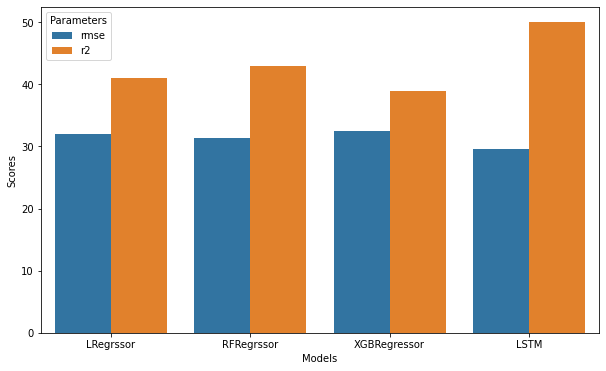

In [58]:
Bar_Plots(LR_score_lst, RF_score_lst, XGB_score_lst, LSTM_score_lst)

In [59]:
def plot_result(y_true,y_pred):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('RUL')
    plt.xlabel('training samples')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('COMPARISION OF Real and Predicted values')
    plt.show()
    return

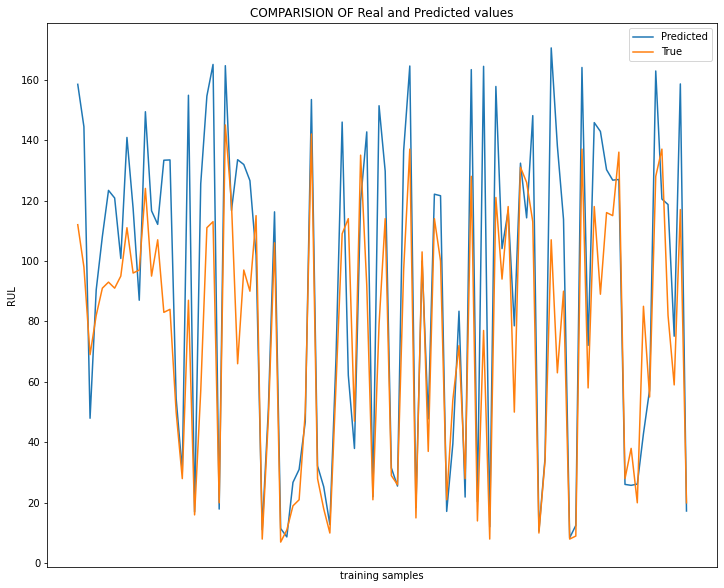

In [60]:
#LSTM
plot_result(rul_test,y_lstm)

Prediction of remaining usage life(RUL) with LSTM model is quite good specially for low RUL. Normal linear regression also predicts well, however with lstm model the we improved the RMSE by 11.3%.

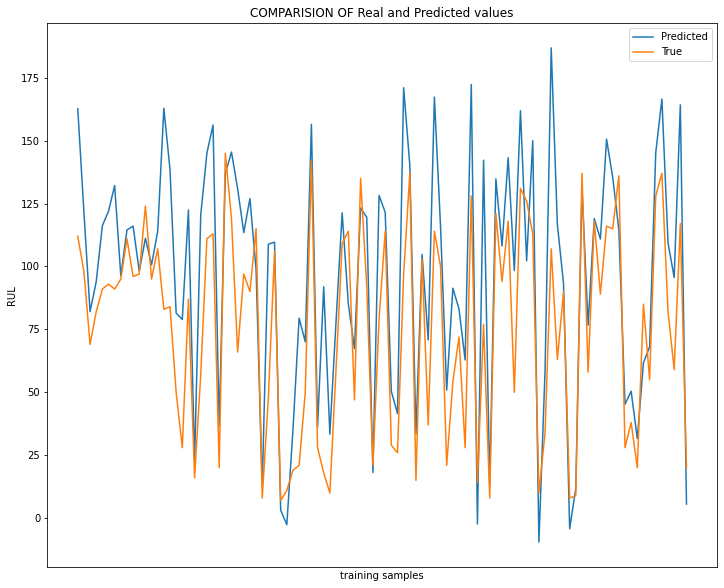

In [61]:
#Linear regression, base model
plot_result(rul_test,y_lr)

We can see that for lower RUL, LSTM predicts better than the linear regression.

# SHAP

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


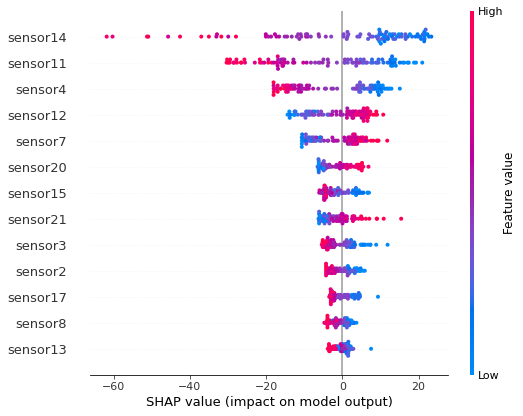

In [62]:
import shap

explainer = shap.TreeExplainer(xg_reg)
# Calculate Shap values
shap_values =shap.TreeExplainer(xg_reg).shap_values(pd.DataFrame(X_test_final, columns=X_test_final.columns))

shap.summary_plot(shap_values, X_test_final, feature_names=X_test_final.columns.tolist())

Sensor 14 and 11 has the highest impact on RUL according to XG_regression model. 

# Conclusion and Future Recommendation
1. LSTM model predicts the RUL quite well with 11.3% improvement to linear regression(base model). Increasing epochs can improve it further.
2. Sensor 14 and 11 impacts the RUL the most.
3. Threshold value of RUL can be set and problem can be solved using a classification model as well.
4. LSTM model will work for other data sets as well with more complicated settings.
5. Better feature selection can improve the model further. However, domain knowledge will play a important role.

# Resources used
1. https://towardsdatascience.com/predictive-maintenance-of-turbofan-engines-ec54a083127
2. https://www.kaggle.com/vinayak123tyagi/damage-propagation-modeling-for-aircraft-engine
3. https://www.kaggle.com/sanchitapaul/nasa-turbofan-degradation-model